# Pong with dqn

## Step 1: Import the libraries

 !!!!  To import all the games    !!!!!

pip install --upgrade git+https://github.com/openai/gym
pip install autorom

AutoRom    

pip install --upgrade gym[atari]



In [83]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math



In [84]:
from sklearn.manifold import Isomap


# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [85]:
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

In [86]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA

In [87]:
import sys
sys.path.append('../../')
from algos.agents.dqn_agent import DQNAgent
from algos.models.dqn_cnn import DQNCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

In [88]:
sys.path.append('../../')
from MIND.src.mind import mind_ensemble

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [89]:
env = gym.make('SpaceInvaders-v0',render_mode='human')

env.seed(0)

(0, 592379725)

In [90]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Step 3: Viewing our Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6
(160, 3)


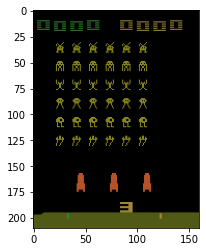

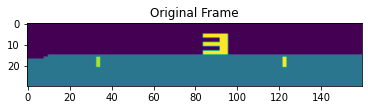

In [91]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
print(env.reset()[1:5][:][0].shape)
#print(env.reset()[1:5][:][0])
plt.figure()
plt.imshow(env.reset())
plt.figure()
plt.imshow(env.reset()[180:210,:,2])
plt.title('Original Frame')
plt.show()

### Execute the code cell below to play Pong with a random policy.

In [92]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/gym/envs/atari/environment.py:257: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  "We strongly suggest supplying `render_mode` when "
2022-03-01 14:09:44.878 python[1355:22605] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f90e573e270>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-01 14:09:44.878 python[1355:22605] Warning: Expected min height of view: (<NSButton: 0x7f90e574f200>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-01 14:09:44.880 python[1355:22605] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f90e57528d0>) to be less than or eq

Your Score at end of game is:  180.0


## Step 4:Preprocessing Frame

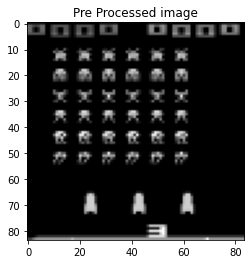

In [11]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [12]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

## Step 6: Creating our Agent

In [19]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 64        # Update batch size
LR = 0.01            # learning rate 
TAU = 1e-3             # for soft update of target parameters
UPDATE_EVERY = 1       # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100         # Rate by which epsilon to be decayed

agent = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)

In [20]:
print(env.action_space.n)

6


## Step 7: Watching untrained agent play


# watch an untrained agent
state = stack_frames(None, env.reset(), True) 
for j in range(200):
    env.render()
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [21]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with DQN

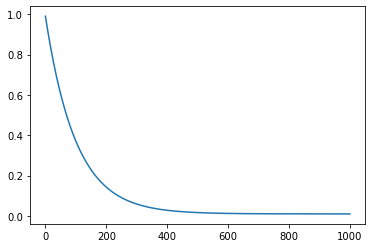

In [22]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

In [23]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
    
    return scores

In [24]:
scores = train(15)

Episode 15	Average Score: 182.33

## Step 10: Watch a Smart Agent!

KeyboardInterrupt: 

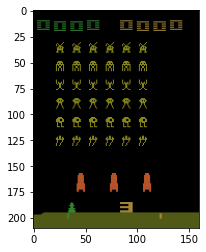

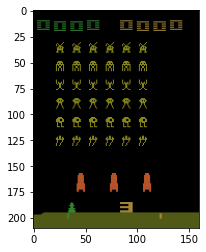

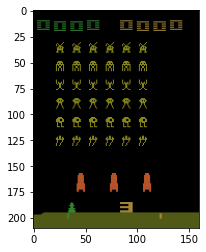

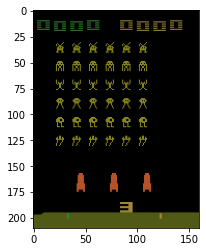

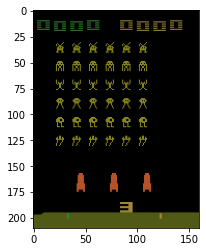

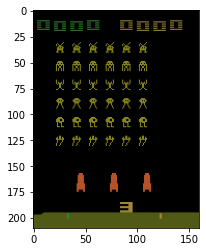

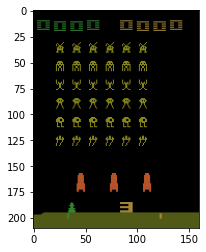

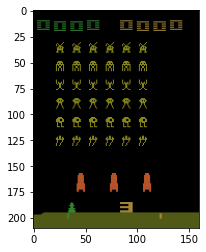

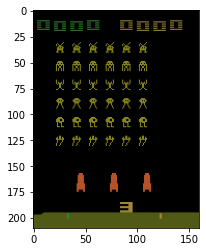

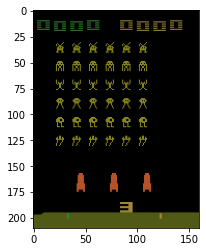

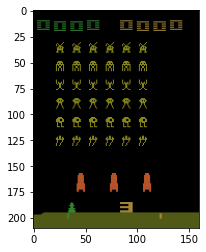

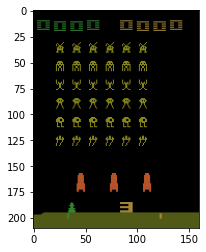

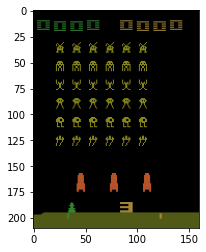

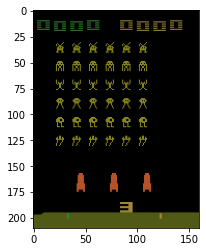

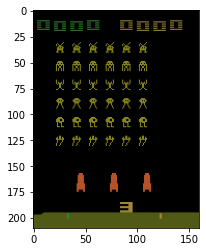

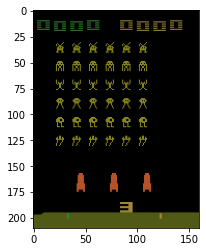

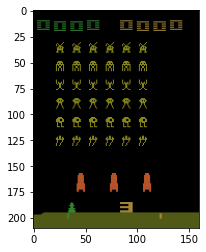

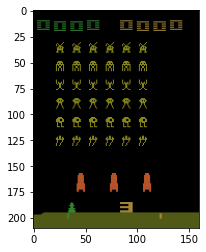

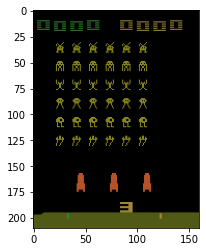

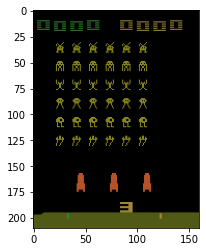

In [36]:
Names_hook = ["fc1","Conv_1","Conv_2","Conv_3"]
Liste_activation = [[] for i in range(len(Names_hook))]
agent.registration()
score = 0
i = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render()
    action = agent.act(state)

    for h in range(len(Names_hook)):
        Liste_activation[h].append(torch.flatten(agent.activation[Names_hook[h]]).unsqueeze(0)) 
    
    next_state, reward, done, _ = env.step(action)
    score += reward
    
    state = stack_frames(state, next_state, False)

    
    i +=1
    if done:
        print("You Final score is:", score)
        print(i)
        break 
env.close()


agent.detach()

print("Shape liste fc1",len(Liste_activation[0]),len(Liste_activation[0][0][0]))
print("Shape liste conv",len(Liste_activation[2]),len(Liste_activation[2][0][0]))


## Step 11: Create the activation Liste

L_activation =torch.zeros([len(Liste_activation), 512], dtype=torch.float64)
Liste = Liste_activation[0]

for i in range(1,len(Liste_activation)):
    Liste = torch.cat((Liste,Liste_activation[i]),0)

Activations = Liste.cpu().detach().numpy()

print(Activations.shape)

## Activation list for convolution layer

In [79]:
LAYER = 0

In [80]:

Liste = Liste_activation[LAYER][0]

for i in range(1,len(Liste_activation[LAYER])):
    Liste = torch.cat((Liste,Liste_activation[LAYER][i]),0)

Activations = Liste.cpu().detach().numpy()

print(Activations.shape)

(712, 512)


(712, 512)
(712, 3)
(712, 12800)
(712, 3)
(712, 5184)
(712, 3)
(712, 3136)
(712, 3)


<Figure size 432x288 with 0 Axes>

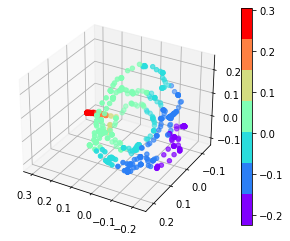

<Figure size 432x288 with 0 Axes>

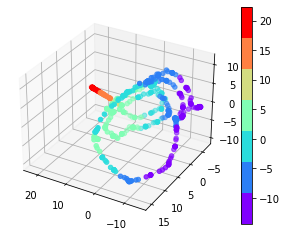

<Figure size 432x288 with 0 Axes>

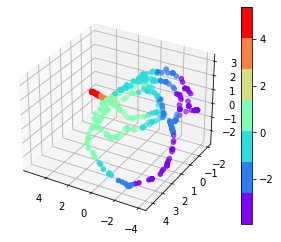

<Figure size 432x288 with 0 Axes>

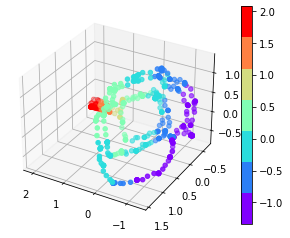

In [83]:
embedding = Isomap(n_neighbors=12,n_components=3)
for h in range(len(Names_hook)):
    
    Liste = Liste_activation[h][0]

    for i in range(1,len(Liste_activation[h])):
        Liste = torch.cat((Liste,Liste_activation[h][i]),0)
    Activations = Liste.cpu().detach().numpy()
    print(Activations.shape)
    X = embedding.fit_transform(Activations)
    print(X.shape)
    colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))
    fig = plt.figure()
    ax = plt.figure().add_subplot(projection='3d')
    sc = ax.scatter3D(X[:, 0], X[:, 1], X[:, 2],
                 **colorize)
    ax.view_init(azim=120, elev=30)
    plt.colorbar(sc)






## Step 12: ISOMAP

In [24]:
embedding = Isomap(n_neighbors=12,n_components=3)

In [47]:
X_conv= embedding.fit_transform(Activations_conv)
print(X_conv.shape)
colorize = dict(c=X_conv[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))

(924, 3)


In [26]:
X_fc1 = embedding.fit_transform(Activations_fc1)
print(X_fc1.shape)
colorize = dict(c=X_fc1[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))

(924, 3)


<Figure size 432x288 with 0 Axes>

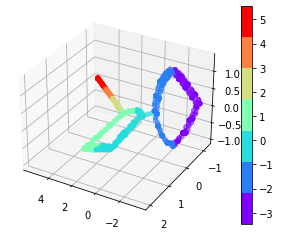

In [48]:
fig = plt.figure()
ax = plt.figure().add_subplot(projection='3d')
sc = ax.scatter3D(X_conv[:, 0], X_conv[:, 1], X_conv[:, 2],
             **colorize)
ax.view_init(azim=120, elev=30)
plt.colorbar(sc)



<Figure size 432x288 with 0 Axes>

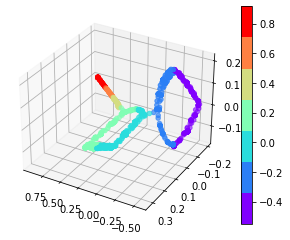

In [41]:
fig = plt.figure()
ax = plt.figure().add_subplot(projection='3d')
sc = ax.scatter3D(X_fc1[:, 0], X_fc1[:, 1], X_fc1[:, 2],
             **colorize)
ax.view_init(azim=120, elev=30)
plt.colorbar(sc)



## MDS

In [52]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(Activations_conv)
D.shape

(924, 924)

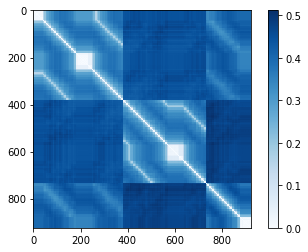

In [53]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

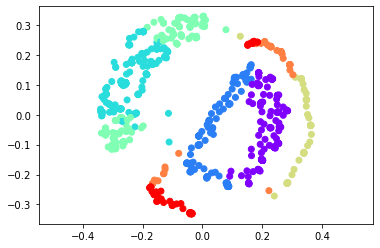

In [54]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

In [82]:
plt.figure(figsize=(40, 30))
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

text = [k for k in range(Activations_conv.shape[0])]

for i in range(len(text)):
    plt.annotate(text[i], (out[i, 0], out[i, 1]))

NameError: name 'out' is not defined

<Figure size 2880x2160 with 0 Axes>

<Figure size 432x288 with 0 Axes>

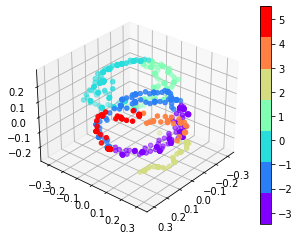

In [57]:
model = MDS(n_components=3, dissimilarity='precomputed', random_state=1)
X = model.fit_transform(D)

fig = plt.figure()
ax = plt.figure().add_subplot(projection='3d')
sc = ax.scatter3D(X[:, 0], X[:, 1], X[:, 2],
             **colorize)
ax.view_init(azim=40, elev=30)
plt.colorbar(sc)

## Other

LLE: 0.4 sec
LTSA: 0.37 sec
Hessian LLE: 0.4 sec
Modified LLE: 0.4 sec
Isomap: 0.35 sec
MDS: 0.81 sec
SE: 0.24 sec


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


t-SNE: 4.4 sec


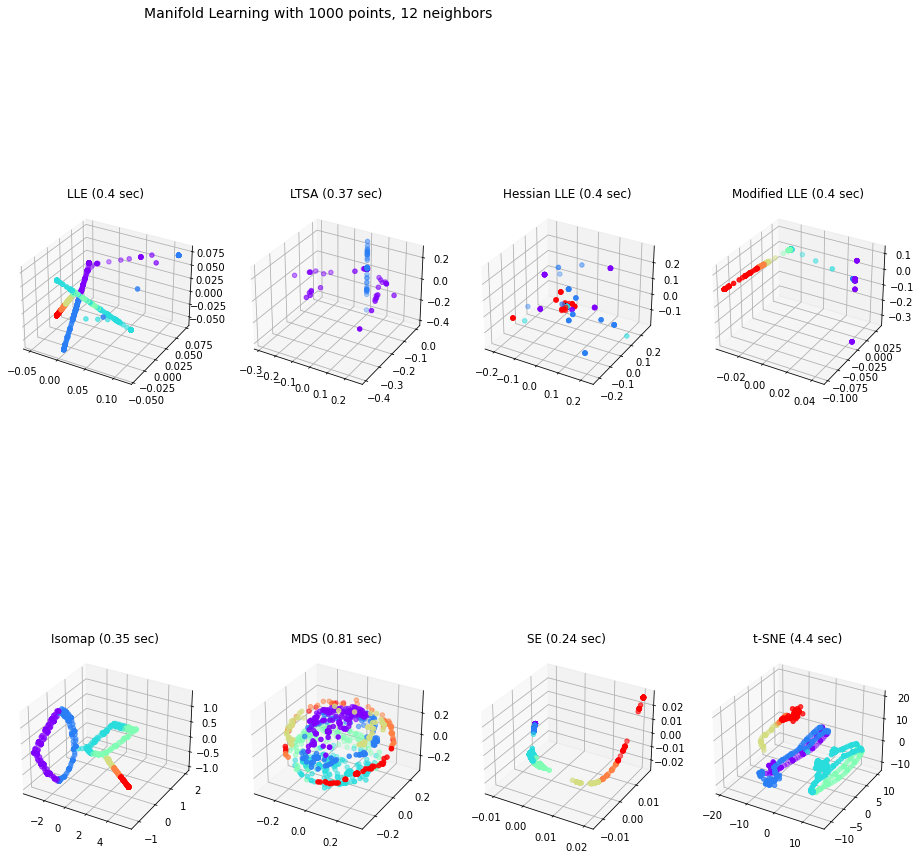

In [58]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X = Activations_conv
n_neighbors = 12
n_components = 3

# Create figure
fig = plt.figure(figsize=(20, 15))
fig.suptitle(
    "Manifold Learning with %i points, %i neighbors" % (1000, n_neighbors), fontsize=14
)



# Set-up manifold methods
LLE = partial(
    manifold.LocallyLinearEmbedding,
    n_neighbors=n_neighbors,
    n_components=n_components,
    eigen_solver="dense",
)

methods = OrderedDict()
methods["LLE"] = LLE(method="standard")
methods["LTSA"] = LLE(method="ltsa")
methods["Hessian LLE"] = LLE(method="hessian")
methods["Modified LLE"] = LLE(method="modified")
methods["Isomap"] = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
methods["MDS"] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods["SE"] = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors
)
methods["t-SNE"] = manifold.TSNE(n_components=n_components, init="pca", random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3),projection="3d")
    sc = ax.scatter3D(Y[:, 0], Y[:, 1],Y[:, 2],  **colorize)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    #ax.xaxis.set_major_formatter(NullFormatter())
    #ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")
    
   # ax.view_init(azim=80, elev=30)
plt.show()

In [ ]:
emb = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
X= emb.fit_transform(Activations)

fig = plt.figure()
ax = plt.figure().add_subplot(projection='3d')
sc = ax.scatter3D(X[:, 0], X[:, 1], X[:, 2],
             **colorize)
ax.view_init(azim=40, elev=30)
plt.colorbar(sc)

In [ ]:
# Sort data by position on manifold
X_sort = Activations[np.argsort(colorize)]
print(colorize.shape)
print(X_sort.shape)
print(Activations.shape)

In [ ]:
m = mind_ensemble(Activations, manifold_dim=2, n_trees=100, seed=123)
m.learn_coordinates()

## Score average during training HPC

In [80]:
scores = [160.0, 110.0, 65.0, 120.0, 30.0, 65.0, 235.0, 210.0, 230.0, 180.0, 110.0, 150.0, 35.0, 30.0, 100.0, 65.0, 195.0, 105.0, 105.0, 80.0, 35.0, 70.0, 100.0, 330.0, 135.0, 205.0, 110.0, 335.0, 345.0, 80.0, 210.0, 470.0, 235.0, 325.0, 110.0, 265.0, 15.0, 30.0, 120.0, 470.0, 135.0, 90.0, 250.0, 300.0, 210.0, 200.0, 280.0, 85.0, 305.0, 470.0, 390.0, 45.0, 70.0, 235.0, 260.0, 205.0, 150.0, 225.0, 215.0, 430.0, 150.0, 205.0, 90.0, 170.0, 290.0, 150.0, 140.0, 195.0, 95.0, 135.0, 70.0, 90.0, 85.0, 50.0, 305.0, 160.0, 45.0, 155.0, 270.0, 30.0, 70.0, 230.0, 225.0, 100.0, 350.0, 135.0, 160.0, 95.0, 280.0, 565.0, 520.0, 305.0, 30.0, 70.0, 105.0, 225.0, 25.0, 405.0, 555.0, 70.0, 130.0, 120.0, 25.0, 215.0, 85.0, 15.0, 55.0, 55.0, 45.0, 10.0, 105.0, 235.0, 195.0, 245.0, 15.0, 80.0, 50.0, 90.0, 425.0, 110.0, 50.0, 135.0, 500.0, 160.0, 65.0, 260.0, 90.0, 215.0, 230.0, 20.0, 50.0, 25.0, 125.0, 385.0, 220.0, 360.0, 435.0, 190.0, 105.0, 175.0, 130.0, 65.0, 10.0, 140.0, 20.0, 170.0, 5.0, 120.0, 55.0, 320.0, 225.0, 15.0, 315.0, 120.0, 70.0, 20.0, 105.0, 280.0, 225.0, 20.0, 100.0, 140.0, 175.0, 155.0, 185.0, 355.0, 360.0, 15.0, 185.0, 535.0, 235.0, 265.0, 185.0, 105.0, 250.0, 10.0, 210.0, 100.0, 165.0, 275.0, 165.0, 180.0, 245.0, 85.0, 185.0, 385.0, 70.0, 75.0, 5.0, 35.0, 40.0, 145.0, 290.0, 75.0, 35.0, 605.0, 25.0, 105.0, 170.0, 165.0, 5.0, 40.0, 150.0, 20.0, 205.0, 315.0, 225.0, 220.0, 115.0, 245.0, 160.0, 510.0, 270.0, 200.0, 330.0, 230.0, 205.0, 335.0, 185.0, 135.0, 105.0, 130.0, 130.0, 20.0, 90.0, 300.0, 50.0, 20.0, 25.0, 150.0, 180.0, 295.0, 10.0, 95.0, 130.0, 85.0, 50.0, 500.0, 50.0, 15.0, 85.0, 35.0, 165.0, 60.0, 255.0, 80.0, 135.0, 115.0, 170.0, 65.0, 190.0, 120.0, 130.0, 275.0, 190.0, 80.0, 155.0, 135.0, 120.0, 60.0, 135.0, 110.0, 360.0, 120.0, 175.0, 210.0, 140.0, 230.0, 335.0, 210.0, 280.0, 440.0, 40.0, 145.0, 165.0, 230.0, 250.0, 120.0, 160.0, 630.0, 50.0, 410.0, 280.0, 160.0, 145.0, 505.0, 65.0, 140.0, 185.0, 130.0, 140.0, 120.0, 70.0, 155.0, 380.0, 140.0, 175.0, 25.0, 5.0, 165.0, 155.0, 100.0, 40.0, 5.0, 55.0, 415.0, 75.0, 100.0, 200.0, 40.0, 195.0, 50.0, 90.0, 345.0, 15.0, 230.0, 75.0, 90.0, 105.0, 110.0, 115.0, 325.0, 30.0, 120.0, 390.0, 490.0, 100.0, 65.0, 50.0, 240.0, 170.0, 25.0, 130.0, 140.0, 130.0, 35.0, 80.0, 35.0, 20.0, 20.0, 430.0, 25.0, 210.0, 490.0, 170.0, 105.0, 140.0, 115.0, 25.0, 20.0, 55.0, 10.0, 605.0, 170.0, 300.0, 75.0, 80.0, 115.0, 170.0, 30.0, 120.0, 415.0, 350.0, 485.0, 290.0, 20.0, 120.0, 75.0, 505.0, 435.0, 60.0, 540.0, 135.0, 75.0, 80.0, 160.0, 80.0, 125.0, 290.0, 5.0, 30.0, 265.0, 500.0, 10.0, 85.0, 85.0, 60.0, 80.0, 235.0, 370.0, 65.0, 95.0, 25.0, 110.0, 105.0, 65.0, 110.0, 65.0, 145.0, 420.0, 365.0, 50.0, 90.0, 55.0, 25.0, 105.0, 10.0, 415.0, 200.0, 55.0, 170.0, 150.0, 70.0, 55.0, 170.0, 125.0, 200.0, 145.0, 225.0, 85.0, 45.0, 445.0, 40.0, 205.0, 230.0, 240.0, 120.0, 245.0, 485.0, 330.0, 5.0, 70.0, 120.0, 60.0, 80.0, 150.0, 50.0, 280.0, 40.0, 145.0, 195.0, 70.0, 235.0, 145.0, 105.0, 310.0, 75.0, 145.0, 55.0, 105.0, 175.0, 315.0, 115.0, 215.0, 260.0, 670.0, 185.0, 100.0, 105.0, 190.0, 45.0, 275.0, 355.0, 100.0, 190.0, 210.0, 110.0, 65.0, 65.0, 35.0, 40.0, 425.0, 230.0, 90.0, 50.0, 190.0, 55.0, 180.0, 230.0, 320.0, 290.0, 245.0, 45.0, 180.0, 105.0, 90.0, 25.0, 140.0, 60.0, 15.0, 40.0, 15.0, 290.0, 145.0, 30.0, 75.0, 160.0, 105.0, 5.0, 50.0, 5.0, 65.0, 85.0, 215.0, 85.0, 265.0, 80.0, 55.0, 80.0, 90.0, 215.0, 460.0, 110.0, 215.0, 85.0, 30.0, 50.0, 35.0, 20.0, 255.0, 610.0, 500.0, 205.0, 110.0, 175.0, 15.0, 90.0, 45.0, 205.0, 215.0, 555.0, 230.0, 110.0, 95.0, 95.0, 30.0, 145.0, 250.0, 110.0, 100.0, 455.0, 390.0, 330.0, 190.0, 290.0, 110.0, 240.0, 400.0, 260.0, 235.0, 205.0, 120.0, 110.0, 20.0, 130.0, 140.0, 285.0, 115.0, 145.0, 125.0, 65.0, 150.0, 135.0, 185.0, 160.0, 375.0, 145.0, 135.0, 70.0, 215.0, 235.0, 45.0, 230.0, 110.0, 65.0, 15.0, 230.0, 170.0, 240.0, 345.0, 235.0, 100.0, 50.0, 155.0, 160.0, 210.0, 125.0, 145.0, 280.0, 85.0, 140.0, 250.0, 115.0, 30.0, 540.0, 430.0, 235.0, 75.0, 285.0, 220.0, 395.0, 135.0, 30.0, 380.0, 155.0, 30.0, 35.0, 70.0, 285.0, 155.0, 40.0, 165.0, 25.0, 455.0, 190.0, 35.0, 115.0, 180.0, 215.0, 45.0, 80.0, 280.0, 65.0, 225.0, 155.0, 30.0, 375.0, 30.0, 340.0, 120.0, 160.0, 325.0, 30.0, 70.0, 15.0, 40.0, 150.0, 85.0, 250.0, 30.0, 465.0, 200.0, 535.0, 305.0, 210.0, 50.0, 380.0, 155.0, 345.0, 365.0, 50.0, 215.0, 110.0, 135.0, 205.0, 95.0, 65.0, 525.0, 80.0, 40.0, 65.0, 165.0, 130.0, 125.0, 195.0, 65.0, 80.0, 155.0, 335.0, 325.0, 150.0, 275.0, 140.0, 240.0, 125.0, 160.0, 140.0, 135.0, 175.0, 315.0, 155.0, 380.0, 65.0, 120.0, 70.0, 290.0, 390.0, 210.0, 110.0, 80.0, 195.0, 150.0, 255.0, 190.0, 155.0, 285.0, 80.0, 110.0, 75.0, 55.0, 305.0, 105.0, 70.0, 265.0, 125.0, 230.0, 280.0, 115.0, 75.0, 235.0, 150.0, 135.0, 430.0, 130.0, 80.0, 200.0, 170.0, 140.0, 185.0, 100.0, 210.0, 55.0, 110.0, 335.0, 120.0, 340.0, 390.0, 125.0, 135.0, 490.0, 115.0, 90.0, 120.0, 75.0, 135.0, 485.0, 435.0, 140.0, 110.0, 120.0, 185.0, 175.0, 80.0, 105.0, 530.0, 350.0, 135.0, 270.0, 60.0, 365.0, 105.0, 500.0, 365.0, 120.0, 75.0, 50.0, 380.0, 485.0, 85.0, 120.0, 120.0, 110.0, 110.0, 110.0, 220.0, 775.0, 105.0, 105.0, 75.0, 415.0, 175.0, 75.0, 80.0, 225.0, 160.0, 60.0, 75.0, 300.0, 190.0, 165.0, 105.0, 55.0, 145.0, 95.0, 110.0, 85.0, 410.0, 75.0, 220.0, 525.0, 490.0, 135.0, 175.0, 1095.0, 120.0, 155.0, 50.0, 265.0, 155.0, 110.0, 345.0, 215.0, 210.0, 105.0, 50.0, 540.0, 195.0, 180.0, 285.0, 430.0, 290.0, 140.0, 335.0, 90.0, 125.0, 135.0, 155.0, 105.0, 140.0, 115.0, 145.0, 140.0, 135.0, 230.0, 160.0, 125.0, 180.0, 350.0, 145.0, 110.0, 410.0, 120.0, 140.0, 290.0, 250.0, 230.0, 270.0, 180.0, 295.0, 560.0, 135.0, 180.0, 75.0, 210.0, 85.0, 225.0, 455.0, 225.0, 140.0, 205.0, 215.0, 415.0, 205.0, 470.0, 150.0, 280.0, 110.0, 405.0, 120.0, 65.0, 555.0, 80.0, 490.0, 520.0, 215.0, 425.0, 470.0, 250.0, 105.0, 630.0, 365.0, 145.0, 165.0, 195.0, 230.0, 540.0, 165.0, 110.0, 320.0, 265.0, 95.0, 180.0, 110.0, 170.0, 235.0, 185.0, 200.0, 210.0, 110.0, 320.0, 130.0, 230.0, 165.0, 355.0, 230.0, 230.0, 180.0, 205.0, 535.0, 50.0, 350.0, 220.0, 390.0, 90.0, 290.0, 130.0, 55.0, 105.0, 190.0, 390.0, 145.0, 115.0, 120.0, 300.0, 85.0, 220.0, 110.0, 140.0, 110.0, 185.0, 120.0, 160.0, 115.0, 730.0, 270.0, 875.0, 135.0, 175.0, 155.0, 220.0, 105.0, 165.0, 135.0, 190.0, 160.0, 135.0, 110.0, 635.0, 100.0, 105.0, 215.0, 80.0, 50.0, 505.0, 85.0, 295.0, 375.0, 135.0, 110.0, 225.0, 210.0, 125.0, 205.0, 125.0, 130.0, 110.0, 110.0, 380.0, 370.0, 495.0, 530.0, 130.0, 200.0, 320.0, 220.0, 280.0, 355.0, 170.0, 100.0, 290.0, 135.0, 80.0, 570.0, 300.0, 365.0, 80.0, 110.0, 105.0, 350.0, 110.0, 105.0, 180.0, 470.0, 630.0, 170.0, 245.0, 110.0, 310.0, 350.0, 170.0, 215.0, 180.0, 170.0, 15.0, 80.0, 105.0, 25.0, 110.0, 200.0, 275.0]
#scores_2 = [60.0, 150.0, 95.0, 135.0, 155.0, 90.0, 215.0, 30.0, 105.0, 105.0, 45.0, 210.0, 210.0, 50.0, 205.0, 110.0, 155.0, 80.0, 200.0, 110.0, 110.0, 95.0, 485.0, 135.0, 75.0, 85.0, 135.0, 155.0, 155.0, 120.0, 55.0, 105.0, 285.0, 130.0, 255.0, 380.0, 105.0, 120.0, 75.0, 155.0, 120.0, 70.0, 205.0, 120.0, 120.0, 170.0, 110.0, 220.0, 295.0, 160.0, 240.0, 155.0, 135.0, 35.0, 220.0, 395.0, 120.0, 520.0, 20.0, 155.0, 75.0, 60.0, 300.0, 160.0, 180.0, 95.0, 195.0, 155.0, 195.0, 200.0, 110.0, 95.0, 220.0, 200.0, 250.0, 320.0, 30.0, 155.0, 130.0, 355.0, 170.0, 375.0, 135.0, 240.0, 165.0, 145.0, 160.0, 40.0, 75.0, 110.0, 120.0, 240.0, 160.0, 130.0, 75.0, 210.0, 80.0, 60.0, 115.0, 440.0, 135.0, 110.0, 70.0, 165.0, 40.0, 230.0, 200.0, 135.0, 110.0, 245.0, 110.0, 65.0, 105.0, 145.0, 210.0, 135.0, 195.0, 495.0, 245.0, 225.0, 135.0, 95.0, 125.0, 350.0, 160.0, 230.0, 200.0, 110.0, 155.0, 205.0, 380.0, 60.0, 190.0, 160.0, 110.0, 830.0, 475.0, 50.0, 710.0, 150.0, 200.0, 105.0, 115.0, 90.0, 105.0, 60.0, 325.0, 280.0, 10.0, 150.0, 165.0, 140.0, 465.0, 705.0, 140.0, 155.0, 120.0, 110.0, 395.0, 190.0, 215.0, 95.0, 160.0, 95.0, 305.0, 80.0, 405.0, 240.0, 80.0, 280.0, 125.0, 315.0, 60.0, 105.0, 190.0, 335.0, 145.0, 205.0, 335.0, 115.0, 290.0, 325.0, 290.0, 50.0, 140.0, 110.0, 170.0, 320.0, 155.0, 55.0, 75.0, 415.0, 290.0, 80.0, 75.0, 290.0, 150.0, 315.0, 260.0, 270.0, 90.0, 150.0, 40.0, 285.0, 150.0, 385.0, 255.0, 175.0, 360.0, 215.0, 220.0, 100.0, 130.0, 330.0, 245.0, 80.0, 320.0, 15.0, 230.0, 520.0, 195.0, 155.0, 240.0, 95.0, 530.0, 140.0, 250.0, 540.0, 350.0, 210.0, 130.0, 445.0, 85.0, 140.0, 35.0, 120.0, 315.0, 160.0, 335.0, 245.0, 230.0, 90.0, 470.0, 425.0, 265.0, 80.0, 230.0, 145.0, 90.0, 340.0, 275.0, 125.0, 145.0, 145.0, 80.0, 380.0, 240.0, 130.0, 205.0, 230.0, 145.0, 130.0, 85.0, 75.0, 400.0, 190.0, 235.0, 310.0, 250.0, 130.0, 100.0, 185.0, 95.0, 190.0, 200.0, 90.0, 345.0, 85.0, 45.0, 375.0, 305.0, 515.0, 655.0, 150.0, 120.0, 20.0, 410.0, 510.0, 295.0, 170.0, 175.0, 205.0, 170.0, 140.0, 310.0, 70.0, 55.0, 215.0, 355.0, 265.0, 75.0, 425.0, 165.0, 270.0, 80.0, 65.0, 385.0, 155.0, 65.0, 60.0, 175.0, 385.0, 135.0, 235.0, 110.0, 195.0, 110.0, 75.0, 225.0, 115.0, 105.0, 50.0, 495.0, 245.0, 220.0, 155.0, 235.0, 70.0, 135.0, 145.0, 180.0, 190.0, 115.0, 20.0, 65.0, 255.0, 55.0, 165.0, 290.0, 55.0, 130.0, 150.0, 100.0, 160.0, 150.0, 115.0, 65.0, 240.0, 90.0, 250.0, 45.0, 95.0, 175.0, 125.0, 100.0, 230.0, 50.0, 265.0, 195.0, 130.0, 455.0, 85.0, 130.0, 410.0, 295.0, 40.0, 75.0, 235.0, 320.0, 155.0, 435.0, 300.0, 220.0, 300.0, 15.0, 285.0, 210.0, 260.0, 270.0, 25.0, 75.0, 195.0, 100.0, 295.0, 50.0, 110.0, 185.0, 190.0, 255.0, 240.0, 425.0, 185.0, 215.0, 400.0, 495.0, 80.0, 335.0, 160.0, 205.0, 190.0, 215.0, 430.0, 285.0, 155.0, 90.0, 145.0, 490.0, 335.0, 150.0, 160.0, 130.0, 140.0, 455.0, 340.0, 190.0, 205.0, 175.0, 735.0, 175.0, 435.0, 235.0, 250.0, 450.0, 300.0, 130.0, 380.0, 150.0, 450.0, 300.0, 515.0, 135.0, 280.0, 180.0, 140.0, 530.0, 170.0, 270.0, 275.0, 140.0, 90.0, 295.0, 260.0, 130.0, 80.0, 255.0, 110.0, 70.0, 330.0, 25.0, 215.0, 80.0, 255.0, 125.0, 185.0, 235.0, 405.0, 445.0, 305.0, 130.0, 400.0, 310.0, 305.0, 75.0, 160.0, 190.0, 115.0, 205.0, 245.0, 490.0, 245.0, 235.0, 195.0, 160.0, 180.0, 215.0, 505.0, 115.0, 230.0, 575.0, 245.0, 110.0, 90.0, 270.0, 220.0, 280.0, 70.0, 200.0, 265.0, 170.0, 150.0, 155.0, 315.0, 195.0, 280.0, 510.0, 100.0, 425.0, 175.0, 130.0, 485.0, 40.0, 640.0, 280.0, 170.0, 260.0, 255.0, 120.0, 110.0, 200.0, 370.0, 180.0, 205.0, 180.0, 250.0, 125.0, 65.0, 205.0, 305.0, 65.0, 105.0, 85.0, 130.0, 155.0, 130.0, 80.0, 195.0, 185.0, 285.0, 110.0, 355.0, 235.0, 140.0, 450.0, 145.0, 70.0, 65.0, 55.0, 340.0, 185.0, 65.0, 75.0, 310.0, 130.0, 170.0, 250.0, 125.0, 275.0, 240.0, 345.0, 245.0, 190.0, 220.0, 85.0, 105.0, 180.0, 445.0, 420.0, 110.0, 290.0, 325.0, 75.0, 160.0, 110.0, 350.0, 185.0, 75.0, 115.0, 455.0, 210.0, 60.0, 215.0, 285.0, 35.0, 255.0, 155.0, 80.0, 115.0, 210.0, 205.0, 180.0, 85.0, 110.0, 340.0, 65.0, 215.0, 380.0, 340.0, 495.0, 75.0, 85.0, 45.0, 615.0, 50.0, 180.0, 315.0, 140.0, 245.0, 120.0, 90.0, 210.0, 210.0, 90.0, 80.0, 245.0, 310.0, 165.0, 240.0, 110.0, 75.0, 105.0, 105.0, 240.0, 255.0, 85.0, 110.0, 145.0, 195.0, 185.0, 110.0, 175.0, 585.0, 75.0, 115.0, 320.0, 180.0, 150.0, 230.0, 160.0, 295.0, 110.0, 110.0, 295.0, 110.0, 135.0, 285.0, 105.0, 190.0, 355.0, 355.0, 345.0, 335.0, 575.0, 155.0, 210.0, 180.0, 215.0, 240.0, 150.0, 165.0, 210.0, 255.0, 80.0, 75.0, 415.0, 530.0, 225.0, 110.0, 50.0, 75.0, 250.0, 80.0, 300.0, 325.0, 525.0, 380.0, 425.0, 155.0, 335.0, 185.0, 75.0, 105.0, 240.0, 260.0, 195.0, 560.0, 210.0, 105.0, 140.0, 75.0, 75.0, 75.0, 155.0, 690.0, 310.0, 555.0, 15.0, 110.0, 110.0, 410.0, 105.0, 70.0, 75.0, 155.0, 120.0, 135.0, 755.0, 110.0, 190.0, 180.0, 210.0, 190.0, 55.0, 160.0, 595.0, 155.0, 155.0, 240.0, 220.0, 135.0, 160.0, 110.0, 430.0, 115.0, 210.0, 110.0, 475.0, 25.0, 145.0, 275.0, 205.0, 320.0, 120.0, 690.0, 105.0, 135.0, 120.0, 295.0, 205.0, 440.0, 155.0, 370.0, 610.0, 155.0, 105.0, 135.0, 75.0, 325.0, 210.0, 20.0, 335.0, 165.0, 175.0, 60.0, 125.0, 400.0, 230.0, 275.0, 295.0, 95.0, 215.0, 450.0, 135.0, 55.0, 220.0, 35.0, 970.0, 285.0, 330.0, 210.0, 185.0, 145.0, 165.0, 210.0, 205.0, 120.0, 520.0, 380.0, 420.0, 215.0, 90.0, 375.0, 320.0, 55.0, 145.0, 215.0, 130.0, 110.0, 75.0, 135.0, 180.0, 35.0, 225.0, 110.0, 215.0, 350.0, 115.0, 210.0, 335.0, 180.0, 105.0, 155.0, 120.0, 110.0, 240.0, 440.0, 335.0, 125.0, 310.0, 260.0, 250.0, 65.0, 135.0, 435.0, 75.0, 160.0, 165.0, 355.0, 50.0, 230.0, 110.0, 155.0, 365.0, 150.0, 420.0, 165.0, 75.0, 225.0, 110.0, 300.0, 60.0, 290.0, 285.0, 55.0, 210.0, 150.0, 510.0, 195.0, 110.0, 180.0, 440.0, 195.0, 45.0, 450.0, 165.0, 245.0, 55.0, 325.0, 450.0, 430.0, 210.0, 160.0, 155.0, 75.0, 130.0, 20.0, 145.0, 185.0, 215.0, 195.0, 105.0, 60.0, 210.0, 350.0, 455.0, 95.0, 110.0, 75.0, 335.0, 155.0, 60.0, 160.0, 140.0, 90.0, 315.0, 55.0, 100.0, 210.0, 55.0, 240.0, 105.0, 45.0, 135.0, 110.0, 115.0, 265.0, 150.0, 415.0, 20.0, 55.0, 210.0, 305.0, 305.0, 160.0, 195.0, 70.0, 215.0, 35.0, 425.0, 35.0, 245.0, 225.0, 530.0, 80.0, 95.0, 355.0, 230.0, 30.0, 160.0, 570.0, 150.0, 220.0, 220.0, 190.0, 115.0, 50.0, 215.0, 130.0, 105.0, 185.0, 130.0, 105.0, 120.0, 135.0, 155.0, 105.0, 210.0, 215.0, 325.0, 230.0, 300.0, 100.0, 110.0, 15.0, 495.0, 150.0, 65.0, 160.0, 80.0, 10.0, 50.0, 235.0, 535.0, 550.0, 75.0, 45.0, 325.0, 40.0, 105.0, 65.0, 155.0, 210.0, 125.0, 230.0, 280.0, 320.0, 190.0, 55.0, 60.0, 550.0, 185.0, 85.0, 345.0, 55.0, 455.0, 345.0, 210.0, 20.0, 500.0, 120.0, 130.0, 125.0, 230.0, 105.0, 80.0, 200.0, 100.0, 140.0, 55.0, 75.0, 85.0, 75.0, 405.0, 310.0, 120.0, 90.0, 220.0, 180.0, 325.0, 30.0, 170.0, 295.0, 150.0, 170.0, 185.0, 185.0, 95.0, 180.0, 415.0, 185.0, 135.0, 145.0, 335.0, 125.0, 160.0, 155.0, 50.0, 160.0, 105.0, 175.0, 315.0]
scores_3 = [60.0, 150.0, 95.0, 135.0, 155.0, 90.0, 215.0, 30.0, 105.0, 105.0, 45.0, 210.0, 210.0, 50.0, 205.0, 110.0, 155.0, 80.0, 200.0, 110.0, 110.0, 95.0, 485.0, 135.0, 75.0, 85.0, 135.0, 155.0, 155.0, 120.0, 55.0, 105.0, 285.0, 130.0, 255.0, 380.0, 105.0, 120.0, 75.0, 155.0, 120.0, 70.0, 205.0, 120.0, 120.0, 170.0, 110.0, 220.0, 295.0, 160.0, 240.0, 155.0, 135.0, 35.0, 220.0, 395.0, 120.0, 520.0, 20.0, 155.0, 75.0, 60.0, 300.0, 160.0, 180.0, 95.0, 195.0, 155.0, 195.0, 200.0, 110.0, 95.0, 220.0, 200.0, 250.0, 320.0, 30.0, 155.0, 130.0, 355.0, 170.0, 375.0, 135.0, 240.0, 165.0, 145.0, 160.0, 40.0, 75.0, 110.0, 120.0, 240.0, 160.0, 130.0, 75.0, 210.0, 80.0, 60.0, 115.0, 440.0, 135.0, 110.0, 70.0, 165.0, 40.0, 230.0, 200.0, 135.0, 110.0, 245.0, 110.0, 65.0, 105.0, 145.0, 210.0, 135.0, 195.0, 495.0, 245.0, 225.0, 135.0, 95.0, 125.0, 350.0, 160.0, 230.0, 200.0, 110.0, 155.0, 205.0, 380.0, 60.0, 190.0, 160.0, 110.0, 830.0, 475.0, 50.0, 710.0, 150.0, 200.0, 105.0, 115.0, 90.0, 105.0, 60.0, 325.0, 280.0, 10.0, 150.0, 165.0, 140.0, 465.0, 705.0, 140.0, 155.0, 120.0, 110.0, 395.0, 190.0, 215.0, 95.0, 160.0, 95.0, 305.0, 80.0, 405.0, 240.0, 80.0, 280.0, 125.0, 315.0, 60.0, 105.0, 190.0, 335.0, 145.0, 205.0, 335.0, 115.0, 290.0, 325.0, 290.0, 50.0, 140.0, 110.0, 170.0, 320.0, 155.0, 55.0, 75.0, 415.0, 290.0, 80.0, 75.0, 290.0, 150.0, 315.0, 260.0, 270.0, 90.0, 150.0, 40.0, 285.0, 150.0, 385.0, 255.0, 175.0, 360.0, 215.0, 220.0, 100.0, 130.0, 330.0, 245.0, 80.0, 320.0, 15.0, 230.0, 520.0, 195.0, 155.0, 240.0, 95.0, 530.0, 140.0, 250.0, 540.0, 350.0, 210.0, 130.0, 445.0, 85.0, 140.0, 35.0, 120.0, 315.0, 160.0, 335.0, 245.0, 230.0, 90.0, 470.0, 425.0, 265.0, 80.0, 230.0, 145.0, 90.0, 340.0, 275.0, 125.0, 145.0, 145.0, 80.0, 380.0, 240.0, 130.0, 205.0, 230.0, 145.0, 130.0, 85.0, 75.0, 400.0, 190.0, 235.0, 310.0, 250.0, 130.0, 100.0, 185.0, 95.0, 190.0, 200.0, 90.0, 345.0, 85.0, 45.0, 375.0, 305.0, 515.0, 655.0, 150.0, 120.0, 20.0, 410.0, 510.0, 295.0, 170.0, 175.0, 205.0, 170.0, 140.0, 310.0, 70.0, 55.0, 215.0, 355.0, 265.0, 75.0, 425.0, 165.0, 270.0, 80.0, 65.0, 385.0, 155.0, 65.0, 60.0, 175.0, 385.0, 135.0, 235.0, 110.0, 195.0, 110.0, 75.0, 225.0, 115.0, 105.0, 50.0, 495.0, 245.0, 220.0, 155.0, 235.0, 70.0, 135.0, 145.0, 180.0, 190.0, 115.0, 20.0, 65.0, 255.0, 55.0, 165.0, 290.0, 55.0, 130.0, 150.0, 100.0, 160.0, 150.0, 115.0, 65.0, 240.0, 90.0, 250.0, 45.0, 95.0, 175.0, 125.0, 100.0, 230.0, 50.0, 265.0, 195.0, 130.0, 455.0, 85.0, 130.0, 410.0, 295.0, 40.0, 75.0, 235.0, 320.0, 155.0, 435.0, 300.0, 220.0, 300.0, 15.0, 285.0, 210.0, 260.0, 270.0, 25.0, 75.0, 195.0, 100.0, 295.0, 50.0, 110.0, 185.0, 190.0, 255.0, 240.0, 425.0, 185.0, 215.0, 400.0, 495.0, 80.0, 335.0, 160.0, 205.0, 190.0, 215.0, 430.0, 285.0, 155.0, 90.0, 145.0, 490.0, 335.0, 150.0, 160.0, 130.0, 140.0, 455.0, 340.0, 190.0, 205.0, 175.0, 735.0, 175.0, 435.0, 235.0, 250.0, 450.0, 300.0, 130.0, 380.0, 150.0, 450.0, 300.0, 515.0, 135.0, 280.0, 180.0, 140.0, 530.0, 170.0, 270.0, 275.0, 140.0, 90.0, 295.0, 260.0, 130.0, 80.0, 255.0, 110.0, 70.0, 330.0, 25.0, 215.0, 80.0, 255.0, 125.0, 185.0, 235.0, 405.0, 445.0, 305.0, 130.0, 400.0, 310.0, 305.0, 75.0, 160.0, 190.0, 115.0, 205.0, 245.0, 490.0, 245.0, 235.0, 195.0, 160.0, 180.0, 215.0, 505.0, 115.0, 230.0, 575.0, 245.0, 110.0, 90.0, 270.0, 220.0, 280.0, 70.0, 200.0, 265.0, 170.0, 150.0, 155.0, 315.0, 195.0, 280.0, 510.0, 100.0, 425.0, 175.0, 130.0, 485.0, 40.0, 640.0, 280.0, 170.0, 260.0, 255.0, 120.0, 110.0, 200.0, 370.0, 180.0, 205.0, 180.0, 250.0, 125.0, 65.0, 205.0, 305.0, 65.0, 105.0, 85.0, 130.0, 155.0, 130.0, 80.0, 195.0, 185.0, 285.0, 110.0, 355.0, 235.0, 140.0, 450.0, 145.0, 70.0, 65.0, 55.0, 340.0, 185.0, 65.0, 75.0, 310.0, 130.0, 170.0, 250.0, 125.0, 275.0, 240.0, 345.0, 245.0, 190.0, 220.0, 85.0, 105.0, 180.0, 445.0, 420.0, 110.0, 290.0, 325.0, 75.0, 160.0, 110.0, 350.0, 185.0, 75.0, 115.0, 455.0, 210.0, 60.0, 215.0, 285.0, 35.0, 255.0, 155.0, 80.0, 115.0, 210.0, 205.0, 180.0, 85.0, 110.0, 340.0, 65.0, 215.0, 380.0, 340.0, 495.0, 75.0, 85.0, 45.0, 615.0, 50.0, 180.0, 315.0, 140.0, 245.0, 120.0, 90.0, 210.0, 210.0, 90.0, 80.0, 245.0, 310.0, 165.0, 240.0, 110.0, 75.0, 105.0, 105.0, 240.0, 255.0, 85.0, 110.0, 145.0, 195.0, 185.0, 110.0, 175.0, 585.0, 75.0, 115.0, 320.0, 180.0, 150.0, 230.0, 160.0, 295.0, 110.0, 110.0, 295.0, 110.0, 135.0, 285.0, 105.0, 190.0, 355.0, 355.0, 345.0, 335.0, 575.0, 155.0, 210.0, 180.0, 215.0, 240.0, 150.0, 165.0, 210.0, 255.0, 80.0, 75.0, 415.0, 530.0, 225.0, 110.0, 50.0, 75.0, 250.0, 80.0, 300.0, 325.0, 525.0, 380.0, 425.0, 155.0, 335.0, 185.0, 75.0, 105.0, 240.0, 260.0, 195.0, 560.0, 210.0, 105.0, 140.0, 75.0, 75.0, 75.0, 155.0, 690.0, 310.0, 555.0, 15.0, 110.0, 110.0, 410.0, 105.0, 70.0, 75.0, 155.0, 120.0, 135.0, 755.0, 110.0, 190.0, 180.0, 210.0, 190.0, 55.0, 160.0, 595.0, 155.0, 155.0, 240.0, 220.0, 135.0, 160.0, 110.0, 430.0, 115.0, 210.0, 110.0, 475.0, 25.0, 145.0, 275.0, 205.0, 320.0, 120.0, 690.0, 105.0, 135.0, 120.0, 295.0, 205.0, 440.0, 155.0, 370.0, 610.0, 155.0, 105.0, 135.0, 75.0, 325.0, 210.0, 20.0, 335.0, 165.0, 175.0, 60.0, 125.0, 400.0, 230.0, 275.0, 295.0, 95.0, 215.0, 450.0, 135.0, 55.0, 220.0, 35.0, 970.0, 285.0, 330.0, 210.0, 185.0, 145.0, 165.0, 210.0, 205.0, 120.0, 520.0, 380.0, 420.0, 215.0, 90.0, 375.0, 320.0, 55.0, 145.0, 215.0, 130.0, 110.0, 75.0, 135.0, 180.0, 35.0, 225.0, 110.0, 215.0, 350.0, 115.0, 210.0, 335.0, 180.0, 105.0, 155.0, 120.0, 110.0, 240.0, 440.0, 335.0, 125.0, 310.0, 260.0, 250.0, 65.0, 135.0, 435.0, 75.0, 160.0, 165.0, 355.0, 50.0, 230.0, 110.0, 155.0, 365.0, 150.0, 420.0, 165.0, 75.0, 225.0, 110.0, 300.0, 60.0, 290.0, 285.0, 55.0, 210.0, 150.0, 510.0, 195.0, 110.0, 180.0, 440.0, 195.0, 45.0, 450.0, 165.0, 245.0, 55.0, 325.0, 450.0, 430.0, 210.0, 160.0, 155.0, 75.0, 130.0, 20.0, 145.0, 185.0, 215.0, 195.0, 105.0, 60.0, 210.0, 350.0, 455.0, 95.0, 110.0, 75.0, 335.0, 155.0, 60.0, 160.0, 140.0, 90.0, 315.0, 55.0, 100.0, 210.0, 55.0, 240.0, 105.0, 45.0, 135.0, 110.0, 115.0, 265.0, 150.0, 415.0, 20.0, 55.0, 210.0, 305.0, 305.0, 160.0, 195.0, 70.0, 215.0, 35.0, 425.0, 35.0, 245.0, 225.0, 530.0, 80.0, 95.0, 355.0, 230.0, 30.0, 160.0, 570.0, 150.0, 220.0, 220.0, 190.0, 115.0, 50.0, 215.0, 130.0, 105.0, 185.0, 130.0, 105.0, 120.0, 135.0, 155.0, 105.0, 210.0, 215.0, 325.0, 230.0, 300.0, 100.0, 110.0, 15.0, 495.0, 150.0, 65.0, 160.0, 80.0, 10.0, 50.0, 235.0, 535.0, 550.0, 75.0, 45.0, 325.0, 40.0, 105.0, 65.0, 155.0, 210.0, 125.0, 230.0, 280.0, 320.0, 190.0, 55.0, 60.0, 550.0, 185.0, 85.0, 345.0, 55.0, 455.0, 345.0, 210.0, 20.0, 500.0, 120.0, 130.0, 125.0, 230.0, 105.0, 80.0, 200.0, 100.0, 140.0, 55.0, 75.0, 85.0, 75.0, 405.0, 310.0, 120.0, 90.0, 220.0, 180.0, 325.0, 30.0, 170.0, 295.0, 150.0, 170.0, 185.0, 185.0, 95.0, 180.0, 415.0, 185.0, 135.0, 145.0, 335.0, 125.0, 160.0, 155.0, 50.0, 160.0, 105.0, 175.0, 315.0, 60.0, 380.0, 125.0, 155.0, 135.0, 135.0, 260.0, 215.0, 210.0, 215.0, 105.0, 410.0, 125.0, 75.0, 185.0, 120.0, 20.0, 210.0, 355.0, 65.0, 105.0, 110.0, 170.0, 100.0, 155.0, 140.0, 225.0, 35.0, 45.0, 210.0, 275.0, 350.0, 135.0, 490.0, 65.0, 315.0, 250.0, 80.0, 365.0, 115.0, 255.0, 215.0, 240.0, 405.0, 25.0, 105.0, 260.0, 85.0, 135.0, 295.0, 255.0, 415.0, 125.0, 155.0, 5.0, 110.0, 185.0, 125.0, 165.0, 155.0, 120.0, 195.0, 330.0, 410.0, 215.0, 185.0, 105.0, 205.0, 240.0, 130.0, 100.0, 165.0, 50.0, 110.0, 105.0, 135.0, 585.0, 140.0, 135.0, 590.0, 135.0, 360.0, 395.0, 35.0, 240.0, 50.0, 175.0, 195.0, 110.0, 145.0, 140.0, 365.0, 770.0, 255.0, 135.0, 85.0, 55.0, 830.0, 470.0, 250.0, 175.0, 170.0, 120.0, 80.0, 210.0, 425.0, 110.0, 110.0, 320.0, 105.0, 165.0, 435.0, 50.0, 385.0, 190.0, 135.0, 105.0, 275.0, 120.0, 105.0, 210.0, 120.0, 65.0, 400.0, 135.0, 105.0, 55.0, 125.0, 125.0, 95.0, 55.0, 190.0, 115.0, 120.0, 110.0, 90.0, 125.0, 210.0, 50.0, 150.0, 745.0, 215.0, 60.0, 265.0, 200.0, 280.0, 210.0, 75.0, 170.0, 55.0, 480.0, 135.0, 60.0, 125.0, 455.0, 190.0, 250.0, 155.0, 480.0, 235.0, 140.0, 155.0, 135.0, 395.0, 155.0, 165.0, 140.0, 180.0, 75.0, 165.0, 80.0, 110.0, 155.0, 190.0, 105.0, 5.0, 75.0, 105.0, 215.0, 80.0, 125.0, 75.0, 90.0, 55.0, 130.0, 120.0, 275.0, 90.0, 45.0, 600.0, 210.0, 110.0, 160.0, 275.0, 125.0, 120.0, 150.0, 210.0, 135.0, 195.0, 215.0, 135.0, 130.0, 105.0, 385.0, 110.0, 95.0, 155.0, 125.0, 185.0, 340.0, 110.0, 120.0, 275.0, 135.0, 395.0, 330.0, 80.0, 340.0, 165.0, 210.0, 340.0, 345.0, 105.0, 165.0, 55.0, 780.0, 225.0, 140.0, 345.0, 140.0, 120.0, 415.0, 395.0, 105.0, 160.0, 270.0, 135.0, 180.0, 80.0, 75.0, 105.0, 405.0, 105.0, 435.0, 380.0, 75.0, 75.0, 125.0, 330.0, 510.0, 340.0, 235.0, 50.0, 165.0, 215.0, 140.0, 105.0, 205.0, 40.0, 95.0, 80.0, 105.0, 185.0, 425.0, 445.0, 250.0, 80.0, 155.0, 65.0, 30.0, 325.0, 235.0, 110.0, 145.0, 180.0, 345.0, 50.0, 405.0, 605.0, 220.0, 135.0, 105.0, 130.0, 480.0, 135.0, 225.0, 225.0, 300.0, 240.0, 220.0, 45.0, 140.0, 230.0, 105.0, 235.0, 190.0, 360.0, 185.0, 115.0, 285.0, 485.0, 120.0, 165.0, 75.0, 85.0, 120.0, 305.0, 290.0, 285.0, 410.0, 120.0, 280.0, 105.0, 105.0, 435.0, 345.0, 435.0, 245.0, 280.0, 175.0, 55.0, 240.0, 160.0, 400.0, 300.0, 80.0, 125.0, 10.0, 390.0, 255.0, 90.0, 105.0, 365.0, 170.0, 210.0, 225.0, 45.0, 135.0, 200.0, 50.0, 295.0, 40.0, 155.0, 185.0, 105.0, 550.0, 245.0, 130.0, 295.0, 325.0, 310.0, 420.0, 25.0, 125.0, 100.0, 170.0, 235.0, 135.0, 445.0, 125.0, 560.0, 105.0, 220.0, 370.0, 265.0, 130.0, 100.0, 175.0, 235.0, 410.0, 125.0, 410.0, 455.0, 275.0, 330.0, 355.0, 360.0, 410.0, 170.0, 205.0, 95.0, 385.0, 50.0, 255.0, 55.0, 205.0, 130.0, 75.0, 110.0, 80.0, 135.0, 210.0, 385.0, 110.0, 205.0, 105.0, 345.0, 215.0, 335.0, 200.0, 305.0, 145.0, 140.0, 150.0, 285.0, 165.0, 260.0, 50.0, 45.0, 55.0, 215.0, 220.0, 140.0, 610.0, 355.0, 595.0, 465.0, 140.0, 175.0, 75.0, 35.0, 110.0, 215.0, 120.0, 185.0, 555.0, 275.0, 395.0, 255.0, 195.0, 140.0, 100.0, 625.0, 190.0, 380.0, 295.0, 230.0, 370.0, 110.0, 260.0, 205.0, 110.0, 60.0, 355.0, 360.0, 265.0, 435.0, 340.0, 185.0, 495.0, 240.0, 380.0, 200.0, 65.0, 320.0, 180.0, 280.0, 255.0, 150.0, 180.0, 520.0, 70.0, 240.0, 230.0, 390.0, 380.0, 105.0, 220.0, 245.0, 115.0, 355.0, 390.0, 135.0, 155.0, 20.0, 100.0, 215.0, 230.0, 410.0, 30.0, 260.0, 185.0, 135.0, 240.0, 70.0, 125.0, 185.0, 225.0, 770.0, 405.0, 585.0, 535.0, 295.0, 175.0, 180.0, 240.0, 260.0, 85.0, 180.0, 140.0, 240.0, 20.0, 125.0, 60.0, 260.0, 245.0, 150.0, 270.0, 275.0, 225.0, 120.0, 395.0, 185.0, 195.0, 205.0, 270.0, 75.0, 160.0, 160.0, 95.0, 180.0, 210.0, 420.0, 185.0, 150.0, 295.0, 440.0, 305.0, 325.0, 110.0, 100.0, 335.0, 225.0, 65.0, 170.0, 55.0, 95.0, 95.0, 105.0, 220.0, 350.0, 40.0, 140.0, 205.0, 240.0, 370.0, 290.0, 235.0, 25.0, 190.0, 280.0, 190.0, 560.0, 95.0, 235.0, 315.0, 410.0, 300.0, 115.0, 140.0, 130.0, 170.0, 155.0, 210.0, 345.0, 185.0, 660.0, 200.0, 170.0, 515.0, 190.0, 260.0, 225.0, 230.0, 535.0, 100.0, 235.0, 200.0, 290.0, 245.0, 180.0, 120.0, 245.0, 110.0, 50.0, 235.0, 445.0, 185.0, 275.0, 135.0, 155.0, 195.0, 455.0, 145.0, 110.0, 175.0, 260.0, 145.0, 265.0, 160.0, 115.0, 135.0, 220.0, 155.0, 125.0, 215.0, 250.0, 155.0, 245.0, 670.0, 175.0, 75.0, 105.0, 205.0, 210.0, 260.0, 120.0, 215.0, 60.0, 115.0, 250.0, 130.0, 230.0, 45.0, 450.0, 75.0, 135.0, 210.0, 105.0, 230.0, 165.0, 75.0, 75.0, 110.0, 345.0, 285.0, 175.0, 145.0, 75.0, 175.0, 80.0, 115.0, 215.0, 310.0, 345.0, 320.0, 125.0, 75.0, 125.0, 225.0, 50.0, 130.0, 505.0, 105.0, 25.0, 160.0, 200.0, 260.0, 105.0, 270.0, 345.0, 80.0, 50.0, 110.0, 105.0, 60.0, 160.0, 195.0, 35.0, 130.0, 310.0, 55.0, 200.0, 255.0, 135.0, 105.0, 75.0, 110.0, 120.0, 235.0, 185.0, 205.0, 105.0, 115.0, 170.0, 120.0, 135.0, 205.0, 85.0, 50.0, 250.0, 265.0, 155.0, 110.0, 465.0, 315.0, 170.0, 110.0, 215.0, 140.0, 380.0, 410.0, 75.0, 60.0, 355.0, 205.0, 210.0, 445.0, 125.0, 210.0, 270.0, 210.0, 165.0, 250.0, 125.0, 425.0, 145.0, 155.0, 105.0, 60.0, 55.0, 210.0, 580.0, 180.0, 75.0, 430.0, 75.0, 220.0, 75.0, 290.0, 105.0, 270.0, 80.0, 75.0, 55.0, 350.0, 80.0, 50.0, 125.0, 120.0, 135.0, 260.0, 125.0, 375.0, 220.0, 275.0, 110.0, 75.0, 105.0, 415.0, 175.0, 190.0, 285.0, 105.0, 210.0, 120.0, 95.0, 90.0, 110.0, 300.0, 230.0, 230.0, 100.0, 425.0, 420.0, 340.0, 340.0, 75.0, 105.0, 415.0, 160.0, 465.0, 395.0, 185.0, 65.0, 155.0, 110.0, 150.0, 105.0, 250.0, 75.0, 105.0, 215.0, 215.0, 150.0, 105.0, 65.0, 90.0, 105.0, 175.0, 410.0, 255.0, 105.0, 270.0, 75.0, 210.0, 75.0, 210.0, 45.0, 270.0, 470.0, 155.0, 75.0, 205.0, 345.0, 105.0, 275.0, 180.0, 80.0, 75.0, 360.0, 235.0, 105.0, 385.0, 35.0, 210.0, 75.0, 255.0, 150.0, 340.0, 55.0, 185.0, 250.0, 210.0, 75.0, 90.0, 215.0, 190.0, 105.0, 315.0, 190.0, 75.0, 380.0, 170.0, 410.0, 110.0, 410.0, 105.0, 115.0, 255.0, 100.0, 215.0, 110.0, 55.0, 105.0, 260.0, 315.0, 355.0, 150.0, 30.0, 165.0, 495.0, 445.0, 135.0, 75.0, 60.0, 125.0, 125.0, 340.0, 620.0, 240.0, 340.0, 375.0, 155.0, 265.0, 430.0, 180.0, 80.0, 75.0, 545.0, 255.0, 75.0, 135.0, 155.0, 210.0, 110.0, 295.0, 280.0, 275.0, 130.0, 45.0, 80.0, 130.0, 75.0, 420.0, 405.0, 85.0, 145.0, 155.0, 125.0, 75.0, 520.0, 435.0, 300.0, 210.0, 185.0, 360.0, 120.0, 180.0, 265.0, 155.0, 265.0, 55.0, 115.0, 455.0, 155.0, 210.0, 110.0, 120.0, 105.0, 230.0, 225.0, 160.0, 350.0, 280.0, 195.0, 225.0, 95.0, 155.0, 110.0, 110.0, 140.0, 370.0, 95.0, 265.0, 365.0, 110.0, 190.0, 260.0, 130.0, 110.0, 215.0, 105.0, 265.0, 390.0, 85.0, 220.0, 575.0, 90.0, 210.0, 110.0, 140.0, 210.0, 55.0, 285.0, 135.0, 155.0, 250.0, 275.0, 435.0, 355.0, 240.0, 255.0, 365.0, 100.0, 305.0, 185.0, 100.0, 250.0, 450.0, 495.0, 505.0, 190.0, 260.0, 300.0, 180.0, 140.0, 120.0, 310.0, 255.0, 155.0, 210.0, 220.0, 415.0, 280.0, 305.0, 210.0, 280.0, 110.0, 250.0, 200.0, 120.0, 175.0, 205.0, 325.0, 120.0, 460.0, 235.0, 115.0, 175.0, 245.0, 95.0, 195.0, 415.0, 435.0, 140.0, 85.0, 155.0, 145.0]
scores_4 = [210.0, 90.0, 120.0, 80.0, 160.0, 65.0, 105.0, 135.0, 210.0, 320.0, 135.0, 210.0, 305.0, 110.0, 110.0, 65.0, 215.0, 20.0, 135.0, 200.0, 140.0, 105.0, 345.0, 170.0, 180.0, 120.0, 215.0, 20.0, 185.0, 90.0, 165.0, 105.0, 210.0, 45.0, 245.0, 370.0, 110.0, 85.0, 60.0, 110.0, 65.0, 60.0, 30.0, 285.0, 155.0, 115.0, 215.0, 90.0, 90.0, 125.0, 210.0, 160.0, 320.0, 110.0, 85.0, 105.0, 140.0, 125.0, 350.0, 335.0, 165.0, 80.0, 405.0, 50.0, 35.0, 220.0, 55.0, 50.0, 30.0, 335.0, 285.0, 65.0, 125.0, 55.0, 90.0, 410.0, 335.0, 170.0, 60.0, 155.0, 235.0, 190.0, 525.0, 155.0, 120.0, 120.0, 160.0, 5.0, 170.0, 170.0, 125.0, 80.0, 330.0, 250.0, 300.0, 300.0, 240.0, 185.0, 185.0, 455.0, 175.0, 330.0, 185.0, 145.0, 180.0, 150.0, 175.0, 130.0, 140.0, 590.0, 185.0, 150.0, 255.0, 440.0, 225.0, 75.0, 45.0, 280.0, 580.0, 75.0, 70.0, 90.0, 220.0, 110.0, 140.0, 180.0, 520.0, 110.0, 100.0, 215.0, 125.0, 340.0, 75.0, 155.0, 430.0, 190.0, 225.0, 190.0, 20.0, 10.0, 75.0, 50.0, 225.0, 290.0, 45.0, 45.0, 170.0, 120.0, 315.0, 90.0, 30.0, 125.0, 155.0, 360.0, 60.0, 235.0, 105.0, 305.0, 260.0, 195.0, 125.0, 255.0, 180.0, 220.0, 105.0, 75.0, 575.0, 235.0, 225.0, 165.0, 20.0, 65.0, 50.0, 105.0, 60.0, 335.0, 135.0, 120.0, 180.0, 325.0, 160.0, 300.0, 190.0, 125.0, 205.0, 555.0, 45.0, 120.0, 185.0, 165.0, 500.0, 160.0, 105.0, 235.0, 105.0, 30.0, 305.0, 100.0, 310.0, 350.0, 105.0, 125.0, 90.0, 180.0, 50.0, 110.0, 105.0, 490.0, 220.0, 300.0, 505.0, 60.0, 375.0, 105.0, 175.0, 245.0, 110.0, 260.0, 70.0, 310.0, 140.0, 110.0, 285.0, 210.0, 340.0, 590.0, 50.0, 390.0, 210.0, 225.0, 30.0, 320.0, 445.0, 530.0, 60.0, 125.0, 55.0, 175.0, 460.0, 215.0, 110.0, 115.0, 140.0, 70.0, 120.0, 80.0, 55.0, 190.0, 185.0, 700.0, 50.0, 155.0, 185.0, 100.0, 195.0, 155.0, 260.0, 210.0, 60.0, 95.0, 160.0, 75.0, 745.0, 155.0, 110.0, 185.0, 35.0, 135.0, 230.0, 380.0, 75.0, 135.0, 475.0, 455.0, 210.0, 300.0, 180.0, 180.0, 185.0, 185.0, 50.0, 220.0, 115.0, 185.0, 245.0, 95.0, 180.0, 380.0, 210.0, 80.0, 270.0, 110.0, 250.0, 370.0, 50.0, 375.0, 135.0, 300.0, 75.0, 75.0, 200.0, 50.0, 230.0, 180.0, 240.0, 130.0, 30.0, 105.0, 125.0, 190.0, 520.0, 360.0, 270.0, 110.0, 345.0, 105.0, 80.0, 180.0, 85.0, 240.0, 105.0, 80.0, 140.0, 110.0, 80.0, 115.0, 80.0, 115.0, 165.0, 115.0, 245.0, 200.0, 420.0, 390.0, 210.0, 350.0, 75.0, 140.0, 120.0, 105.0, 90.0, 135.0, 240.0, 250.0, 120.0, 20.0, 190.0, 610.0, 50.0, 130.0, 25.0, 210.0, 110.0, 360.0, 240.0, 130.0, 165.0, 50.0, 205.0, 35.0, 115.0, 705.0, 420.0, 210.0, 135.0, 110.0, 155.0, 55.0, 240.0, 325.0, 380.0, 40.0, 140.0, 395.0, 165.0, 85.0, 475.0, 160.0, 160.0, 240.0, 160.0, 280.0, 130.0, 255.0, 155.0, 170.0, 105.0, 335.0, 365.0, 105.0, 105.0, 380.0, 280.0, 215.0, 115.0, 80.0, 180.0, 210.0, 730.0, 210.0, 300.0, 480.0, 55.0, 130.0, 210.0, 105.0, 300.0, 25.0, 155.0, 290.0, 215.0, 195.0, 110.0, 145.0, 205.0, 30.0, 565.0, 470.0, 230.0, 295.0, 140.0, 125.0, 105.0, 190.0, 75.0, 105.0, 80.0, 400.0, 160.0, 35.0, 250.0, 270.0, 195.0, 195.0, 440.0, 105.0, 75.0, 420.0, 155.0, 120.0, 265.0, 105.0, 105.0, 480.0, 155.0, 160.0, 480.0, 330.0, 45.0, 300.0, 625.0, 105.0, 180.0, 85.0, 495.0, 220.0, 165.0, 190.0, 100.0, 80.0, 80.0, 245.0, 115.0, 285.0, 145.0, 80.0, 80.0, 685.0, 325.0, 180.0, 265.0, 580.0, 300.0, 230.0, 315.0, 250.0, 365.0, 340.0, 195.0, 215.0, 470.0, 530.0, 75.0, 135.0, 165.0, 335.0, 145.0, 185.0, 15.0, 110.0, 180.0, 255.0, 425.0, 215.0, 115.0, 245.0, 120.0, 180.0, 360.0, 340.0, 200.0, 260.0, 530.0, 215.0, 245.0, 125.0, 410.0, 220.0, 225.0, 100.0, 275.0, 170.0, 125.0, 135.0, 170.0, 340.0, 490.0, 415.0, 250.0, 205.0, 100.0, 355.0, 120.0, 275.0, 180.0, 260.0, 165.0, 205.0, 300.0, 420.0, 200.0, 295.0, 230.0, 260.0, 75.0, 105.0, 275.0, 155.0, 240.0, 145.0, 65.0, 80.0, 75.0, 110.0, 190.0, 325.0, 355.0, 230.0, 120.0, 250.0, 265.0, 150.0, 110.0, 85.0, 145.0, 290.0, 260.0, 180.0, 190.0, 275.0, 380.0, 95.0, 225.0, 165.0, 140.0, 150.0, 165.0, 130.0, 215.0, 55.0, 725.0, 365.0, 190.0, 110.0, 55.0, 155.0, 160.0, 120.0, 295.0, 105.0, 150.0, 340.0, 195.0, 290.0, 60.0, 40.0, 90.0, 135.0, 90.0, 300.0, 165.0, 115.0, 110.0, 215.0, 415.0, 315.0, 135.0, 105.0, 255.0, 215.0, 185.0, 120.0, 395.0, 565.0, 475.0, 440.0, 155.0, 225.0, 85.0, 95.0, 240.0, 195.0, 140.0, 255.0, 540.0, 110.0, 230.0, 725.0, 245.0, 205.0, 245.0, 590.0, 145.0, 210.0, 170.0, 470.0, 150.0, 220.0, 310.0, 170.0, 160.0, 160.0, 700.0, 225.0, 335.0, 130.0, 225.0, 285.0, 360.0, 185.0, 130.0, 140.0, 490.0, 260.0, 205.0, 205.0, 140.0, 155.0, 225.0, 75.0, 195.0, 195.0, 230.0, 180.0, 185.0, 260.0, 335.0, 60.0, 265.0, 240.0, 165.0, 445.0, 215.0, 205.0, 475.0, 305.0, 135.0, 220.0, 170.0, 340.0, 55.0, 130.0, 110.0, 95.0, 80.0, 255.0, 95.0, 115.0, 565.0, 200.0, 165.0, 125.0, 55.0, 110.0, 490.0, 110.0, 320.0, 235.0, 130.0, 135.0, 180.0, 90.0, 280.0, 85.0, 220.0, 130.0, 530.0, 210.0, 50.0, 455.0, 300.0, 65.0, 130.0, 40.0, 150.0, 190.0, 730.0, 260.0, 400.0, 295.0, 210.0, 160.0, 205.0, 130.0, 235.0, 255.0, 165.0, 315.0, 125.0, 85.0, 200.0, 210.0, 335.0, 215.0, 105.0, 185.0, 110.0, 250.0, 515.0, 140.0, 255.0, 110.0, 155.0, 115.0, 195.0, 290.0, 135.0, 135.0, 105.0, 405.0, 120.0, 330.0, 45.0, 210.0, 140.0, 225.0, 140.0, 375.0, 400.0, 105.0, 110.0, 195.0, 110.0, 85.0, 80.0, 565.0, 205.0, 480.0, 55.0, 110.0, 140.0, 365.0, 110.0, 110.0, 285.0, 385.0, 155.0, 155.0, 105.0, 255.0, 205.0, 205.0, 280.0, 295.0, 245.0, 300.0, 135.0, 180.0, 120.0, 445.0, 15.0, 255.0, 135.0, 105.0, 190.0, 585.0, 305.0, 135.0, 105.0, 25.0, 270.0, 110.0, 155.0, 90.0, 270.0, 190.0, 210.0, 360.0, 160.0, 70.0, 150.0, 110.0, 150.0, 150.0, 265.0, 110.0, 250.0, 210.0, 15.0, 105.0, 335.0, 375.0, 50.0, 195.0, 85.0, 110.0, 375.0, 215.0, 200.0, 155.0, 110.0, 210.0, 180.0, 155.0, 155.0, 110.0, 80.0, 115.0, 285.0, 110.0, 285.0, 30.0, 185.0, 45.0, 40.0, 240.0, 120.0, 145.0, 95.0, 110.0, 355.0, 130.0, 100.0, 165.0, 190.0, 105.0, 55.0, 240.0, 185.0, 135.0, 190.0, 100.0, 185.0, 105.0, 310.0, 440.0, 330.0, 220.0, 205.0, 180.0, 320.0, 280.0, 45.0, 475.0, 160.0, 150.0, 345.0, 245.0, 85.0, 100.0, 140.0, 330.0, 70.0, 275.0, 165.0, 450.0, 85.0, 275.0, 210.0, 205.0, 20.0, 290.0, 200.0, 205.0, 130.0, 125.0, 50.0, 180.0, 185.0, 155.0, 265.0, 100.0, 190.0, 145.0, 135.0, 20.0, 50.0, 125.0, 415.0, 95.0, 90.0, 110.0, 160.0, 190.0, 250.0, 125.0, 80.0, 185.0, 155.0, 230.0, 585.0, 40.0, 130.0, 210.0, 185.0, 75.0, 80.0, 150.0, 250.0, 105.0, 195.0, 150.0, 320.0, 295.0, 70.0, 215.0, 230.0, 130.0, 265.0, 145.0, 85.0, 160.0, 140.0, 305.0, 330.0, 140.0, 185.0, 120.0, 185.0, 140.0, 195.0, 185.0, 90.0, 135.0, 100.0, 190.0, 220.0, 270.0, 230.0, 145.0, 140.0, 145.0, 170.0, 270.0, 315.0, 185.0, 205.0, 85.0, 30.0, 120.0, 150.0, 385.0, 195.0, 250.0, 25.0, 265.0, 245.0, 220.0, 250.0, 125.0, 45.0, 225.0, 110.0, 90.0, 210.0, 180.0, 285.0, 300.0, 135.0, 110.0, 260.0, 90.0, 610.0, 115.0, 150.0, 315.0, 245.0, 265.0, 195.0, 305.0, 95.0, 230.0, 165.0, 200.0, 95.0, 100.0, 180.0, 245.0, 165.0, 415.0]

SCORES = scores+scores_3 + scores_4
print(len(SCORES))
Moyen_score = [np.mean(SCORES[i:(i+1)*10]) for i in range(int(np.floor(len(SCORES)/10))) for a in range(10)]

4000


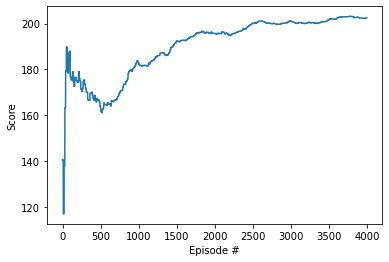

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(SCORES)),Moyen_score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
            